# Test the affect of an intercept in de-meaning subsequent features
2024.12.16

- Wyatt and I had a discussion on the bus back from CT about whether a factor model should explicitly de-mean features like momentum relative to the cross-sectional value on any given day. 
- I argued that the addition of an intercept means we don't need to explicitly de-mean our features -- though the coefficients will be different, the predictive power of the regression will be the same
- Let's see which one is right!

## Methodology:

- Sample from a synthetic correlated distribution of X and Y
- Add a noise to Y distributed according to $\epsilon \sim N(1, 1)$ for the intercept term
- Increment the values of X by 1 across the vector

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

np.random.seed(42)

### Generate synthetic data

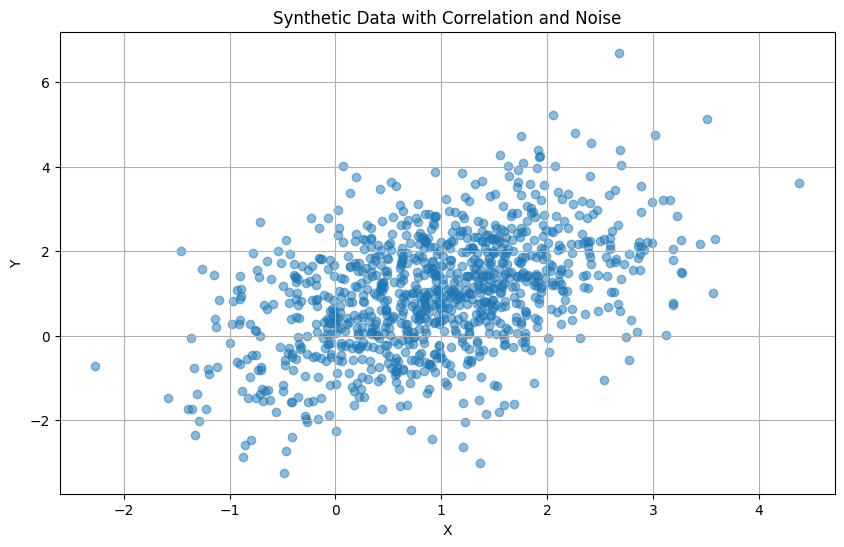

In [2]:
# Generate correlated X and Y data
n_samples = 1000
mean = [0, 0]
cov = [[1, 0.7], 
       [0.7, 1]]
       
X, Y = np.random.multivariate_normal(mean, cov, n_samples).T

# Store original data
X_orig = X.copy()
Y_orig = Y.copy()

# Add noise term distributed as N(1,1)
noise = np.random.normal(1, 1, n_samples)
Y = Y + noise

# Increment X values by 1
X = X + 1

plt.figure(figsize=(10,6))
plt.scatter(X, Y, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Synthetic Data with Correlation and Noise')
plt.grid(True)
plt.show()


### a) Regression, no demeaning

In [3]:
X_no_demeaning = sm.add_constant(X.copy())
Y_no_demeaning = Y.copy()
model_no_demeaning = sm.OLS(Y_no_demeaning, X_no_demeaning).fit()
model_no_demeaning.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     256.8
Date:                Mon, 16 Dec 2024   Prob (F-statistic):           1.32e-51
Time:                        16:52:39   Log-Likelihood:                -1617.5
No. Observations:                1000   AIC:                             3239.
Df Residuals:                     998   BIC:                             3249.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3932      0.054      7.287      0.000       0.287       0.499
x1             0.6377      0.040     16.025      0.000       0.560       0.716
==============================================================================
Omnibus:                        0.915   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.633   Jarque-Bera (JB):                0.790
Skew:                           0.012   Prob(JB):                        0.674
Kurtosis:                       3.136   Cond. No.                         2.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### b) Regression, demean X

In [4]:
X_demeaned = sm.add_constant(X - X.mean())
y_demeaned = Y.copy()
model_demeaned = sm.OLS(y_demeaned, X_demeaned).fit()
model_demeaned.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     256.8
Date:                Mon, 16 Dec 2024   Prob (F-statistic):           1.32e-51
Time:                        16:52:41   Log-Likelihood:                -1617.5
No. Observations:                1000   AIC:                             3239.
Df Residuals:                     998   BIC:                             3249.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9973      0.039     25.832      0.000       0.922       1.073
x1             0.6377      0.040     16.025      0.000       0.560       0.716
==============================================================================
Omnibus:                        0.915   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.633   Jarque-Bera (JB):                0.790
Skew:                           0.012   Prob(JB):                        0.674
Kurtosis:                       3.136   Cond. No.                         1.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Summary

- As expected, the predictive power of the regression does not change with demeaning X
- Further, the significance of X (measured by the T-score) does not change. This is because the measurement of T scores already demeans X
- However, we see that the significance of the constant term (T-score) does significantly increase, and the magnitude of the coefficient changes. This is because some of the "true" allocation to the constant was obfuscated by adding some noise to our X variable, which we have now demeaned
- In the context of a factor model, the attribution of returns to market risk on any given day/month across assets is very important to have in correct magnitude. So, even if the predictive power for returns is unchanged, because we want to analyze the factor returns themselves, it makes sense to demean all the features such that we have appropriate weight on our constant term

## Extension: What about noisy additions?

- Let's say that, instead of incrementing X by 1, we increment it by another Gaussian $\epsilon_X \sim N(1, 1)$
- Does the observation above still hold true that the predictive power is identical? What about the affect on the coefficients?
- I think this better captures the factor model use case, because the "mean of momentum" across a cross-section of assets will be subject to noise, momentum is a noisy measure of something that we think predicts investor behavior

### a) no demeaning

In [16]:
epsilon_X = np.random.normal(1, 1, n_samples)
X_noised_no_demeaning = sm.add_constant(X_orig + epsilon_X)
y_noised_no_demeaning = Y.copy()

model_noised_no_demeaning = sm.OLS(y_noised_no_demeaning, X_noised_no_demeaning).fit()
model_noised_no_demeaning.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     122.7
Date:                Mon, 16 Dec 2024   Prob (F-statistic):           5.51e-27
Time:                        17:00:38   Log-Likelihood:                -1674.0
No. Observations:                1000   AIC:                             3352.
Df Residuals:                     998   BIC:                             3362.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7050      0.049     14.497      0.000       0.610       0.800
x1             0.3255      0.029     11.079      0.000       0.268       0.383
==============================================================================
Omnibus:                        2.965   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.227   Jarque-Bera (JB):                3.103
Skew:                          -0.053   Prob(JB):                        0.212
Kurtosis:                       3.251   Cond. No.                         2.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### b) demeaned

In [17]:
X_noised_demeaned = sm.add_constant(X_noised_no_demeaning[:, 1] - X_noised_no_demeaning[:, 1].mean())
y_noised_demeaned = Y.copy()

model_noised_demeaned = sm.OLS(y_noised_demeaned, X_noised_demeaned).fit()
model_noised_demeaned.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     122.7
Date:                Mon, 16 Dec 2024   Prob (F-statistic):           5.51e-27
Time:                        17:00:38   Log-Likelihood:                -1674.0
No. Observations:                1000   AIC:                             3352.
Df Residuals:                     998   BIC:                             3362.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9973      0.041     24.413      0.000       0.917       1.077
x1             0.3255      0.029     11.079      0.000       0.268       0.383
==============================================================================
Omnibus:                        2.965   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.227   Jarque-Bera (JB):                3.103
Skew:                          -0.053   Prob(JB):                        0.212
Kurtosis:                       3.251   Cond. No.                         1.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Summary of Extension

- Largely, even with noise added through a distribution instead of a constant term, we see the exact same effects play out on the magnitude and significance of the constant term
- **For interpretability in a factor model, it is thus necessary to de-mean one's X values (factor loadings)**